#### Notes

In order to change the parameter `a` that controls how the sampler moves during its walk, you need to update the `emcee` package to the most recent version. To do this, run `pip install --upgrade emcee`.

Note that older notebooks will not work with this newer version, but any code that uses `fit2d` to run the MCMC will handle the version change. If you really need to run an older notebook (though it should be easy to port those parameters to a notebook based off this one) you can downgrade the version using `pip install emcee==2.2.1`.

This notebook, and any other code using `fit2d`, can run on the older version of emcee but you won't be able to change the move parameter. 

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("/Users/stephencoffey/Downloads/little-things/fit2d"))

from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import os

import emcee
from emcee import EnsembleSampler, moves
from fit2d._velocity_field_generator import create_2d_velocity_field

In [2]:
# number of bins in fit
num_bins = 10

# min and max bounds for each bin
vmin, vmax = 0., 200.

# min and max inc, pos angle in RADIANS
inc_min , inc_max = np.radians(55), np.radians(75)
pos_angle_min, pos_angle_max = np.radians(25), np.radians(55)

name = "NGC2366"
distance = 3400. # [kpc]
observed_2d_vel_field_fits_file = "/Users/stephencoffey/Downloads/little-things/data/NGC2366_1mom.fits"
# to use the dispersion as a source of errors, provide this file name
observed_2d_dispersion_fits_file = "/Users/stephencoffey/Downloads/little-things/data/NGC2366_2mom.fits"
deg_per_pixel=4.17e-4

ring_param_file = "/Users/stephencoffey/Downloads/little-things/data/NGC2366_ring_parameters_rohit.txt"
v_systemic = 99.066
 
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

mask_sigma=1.
random_seed = 1234

mcmc_nwalkers = 20
mcmc_niter = 1000
mcmc_ndim = 3  # Do not change this if fitting one ring at a time
mcmc_nthreads = 4
# Try increasing stretch scale factor a. version must be >=3 for this to be used.
mcmc_moves = moves.StretchMove(a = 2)
mcmc_version = float(emcee.__version__[0])

# Option to save every batch_size iterations in case of crash
# Increase this; 2 is a very low value just for testing
batch_size = 100

# option to save outputs in a particular directory
save_dir = "/Volumes/My Passport for Mac/Pickle Files/NGC2366 pkl/fit_fake_obs"

### This is where you can provide a 2D array of pixel errors.
### Only one of these should be set- SET THE OTHER TO HAVE value `None`

#### Note the order the parameters are specified in the `ring_param_bounds`:  index 1 corresponds to the inclination, index 2 corresponds to position angle. 

In [3]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic, 
    observed_2d_dispersion_fits_file=observed_2d_dispersion_fits_file
)

ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)
ring_param_bounds = [(vmin, vmax), (inc_min, inc_max), (pos_angle_min, pos_angle_max)]

# mapping of ring struct params to their index in the parameters (same as specified in bounds)
# this is provided as an optional argument to lnlike to tell it which parameters to use as inc and pos_angle
fit_structural_params = {"inc": 1, "pos_angle": 2}

bin_edges = np.linspace(ring_model.radii_kpc[0], ring_model.radii_kpc[-1], num_bins+1)
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2. for i in range(num_bins)]

/Users/stephencoffey/anaconda2/envs/anna_env/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Users/stephencoffey/anaconda2/envs/anna_env/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [4]:
# One, but not both, should be provided to lnlike

v_err_const = 10. # [km/s] constant error per pixel
v_err_2d = None

# to use the 2nd moment map,
# v_err_const = None
    #v_err_2d = galaxy.observed_2d_dispersion

The code below has been altered to change the "observations" to a fake array
with a constant circular velocity at all radii.

Set the variable `v_rot_fake` to the constant velocity


Done with emcee fit for NGC2366


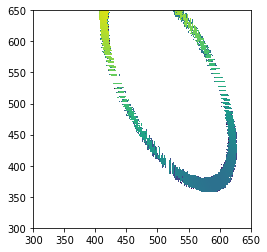

In [7]:
import warnings
warnings.simplefilter('ignore')

v_rot_fake = 50.0   # fill this in with something within the priors

for bin_index in range(6,9):
    bin_min, bin_max = bin_edges[bin_index], bin_edges[bin_index+1]
    
    # the block here replaces the observed galaxy velocity field data with "fake" disk of
    # constant rotational velocity v_rot_fake
    fake_observed_2d_vel_field =create_2d_velocity_field(
        radii = [bin_min, bin_max],
        v_rot = [v_rot_fake, v_rot_fake],  # just fill in any velocity
        ring_model = ring_model,
        kpc_per_pixel = galaxy.kpc_per_pixel,
        v_systemic = galaxy.v_systemic,
        image_xdim = galaxy.image_xdim,
        image_ydim = galaxy.image_ydim
    )
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    plt.imshow(fake_observed_2d_vel_field)
    plt.xlim(300,650)
    plt.ylim(300,650)
    """
    galaxy.observed_2d_vel_field = fake_observed_2d_vel_field
    
    piecewise_model = PiecewiseModel(num_bins=1)
    piecewise_model.set_bounds(array_bounds=ring_param_bounds)
    
    piecewise_model.set_bin_edges(rmin=bin_min, rmax=bin_max)
    radii_to_interpolate = np.array([r for r in ring_model.radii_kpc if bin_min<r<bin_max])                              

    prior = LinearPrior(bounds=piecewise_model.bounds)
    prior_transform = prior.transform_from_unit_cube
    start_positions = piecewise_start_points(mcmc_nwalkers, piecewise_model.bounds, random_seed=random_seed)  
    
    fit_inputs = {
        "piecewise_model": piecewise_model,
        "galaxy": galaxy,
        "ring_model": ring_model,
        "prior_transform": prior_transform
    }
    
    print(f"Fitting ring {bin_index}")
    
    rotation_curve_func_kwargs = {
        "radii_to_interpolate": radii_to_interpolate}
  
    lnlike_args = {
        "model": piecewise_model,
        "rotation_curve_func_kwargs": rotation_curve_func_kwargs, 
        "galaxy": galaxy, 
        "ring_model": ring_model, 
        "mask_sigma": mask_sigma,
        "v_err_const": v_err_const,
        "v_err_2d": v_err_2d,
        "fit_structural_params": fit_structural_params
        }

    sampler = EnsembleSampler(
        mcmc_nwalkers,
        mcmc_ndim, 
        emcee_lnlike, 
        args=[mcmc_version, lnlike_args], 
        threads=mcmc_nthreads,
    )
    if mcmc_version >= 3:
        sampler._moves = [mcmc_moves]

    sampler_output_file = os.path.join(
        save_dir or "", f"sampler_{galaxy.name}_ring{bin_index}_{bin_min:.2f}-{bin_max:.2f}.pkl")
    for batch in range(mcmc_niter // batch_size):
        if batch == 0:
            batch_start = start_positions
        else:
            batch_start = None
            sampler.pool = temp_pool
        sampler.run_mcmc(batch_start, batch_size)
        temp_pool = sampler.pool
        del sampler.pool
        with open(sampler_output_file, 'wb') as f:
            sampler_copy = copy.copy(sampler)
            del sampler_copy.log_prob_fn
            joblib.dump(sampler_copy, f)
        print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_niter}")"""

print(f"Done with emcee fit for {galaxy.name}")

In [16]:
# example of how to load the pickled objects
# change the name of the files to whatever yours were saved as
d = {}
for i in range(6,7):
    bin_min, bin_max = bin_edges[i], bin_edges[i+1]
    with open(f'{save_dir}/sampler_{name}_ring{i}_{bin_min:.2f}-{bin_max:.2f}.pkl', 'rb') as f:
        d[f'saved_sampler_{name}_ring{i}'] = joblib.load(f)

In [6]:
from fit2d.analysis.emcee import get_output_files, combine_results_statistics, get_sampler_statistics, plot_walker_paths, plot_posterior_distributions

# pass the galaxy name, if you specified a particular save directory provide it as argument dir
output_files = get_output_files(galaxy_name=name, dir=save_dir)
print(output_files)
mean, std = combine_results_statistics(
    output_files,
    min_iter=0,
    max_iter=1000)

['/Volumes/My Passport for Mac/Pickle Files/NGC2366 pkl/fit_fake_obs/sampler_NGC2366_ring6_3.18-3.70.pkl']


AssertionError: Number of param_names must equal number of parameters in sampler.

In [17]:
# min_iter / max_iter: can use to limit the iterations used to calculate values
for sampler in d.values():
    get_sampler_statistics(sampler, min_iter=0, max_iter=1000)

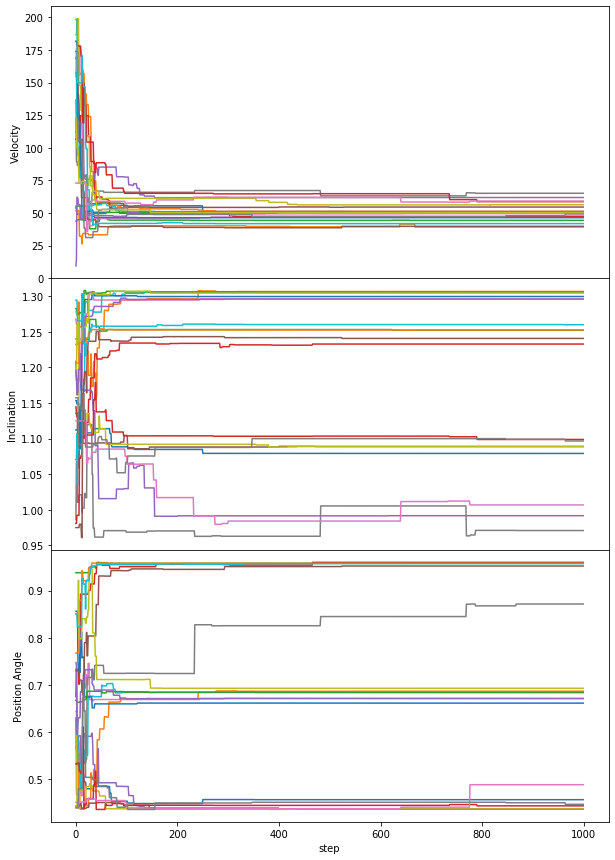

In [18]:
# param_names =  optional list of parameter names, in same order as when fit. Can leave as None.
# min_iter / max_iter: can use to limit the iterations shown in chain
for sampler in d.values():
    walker_paths_figure = plot_walker_paths(sampler, param_names=['Velocity','Inclination','Position Angle'], min_iter=0, max_iter=1000)

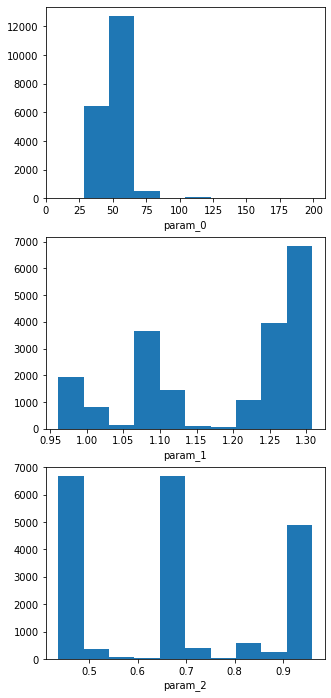

In [19]:
for sampler in d.values():
    posterior_distriubtion_figures = plot_posterior_distributions(
        sampler, min_iter=0, max_iter=1000)

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

# BBarolo Parameters
radii, vels = np.loadtxt(ring_param_file, usecols = (0,2)).T
inclination, posangle = np.loadtxt(ring_param_file, usecols = (4,5)).T

# Little Things 
LT_radii, LT_vels = np.loadtxt("/Users/stephencoffey/Downloads/little-things/data/LT_NGC2366_vels.txt", unpack = True)
LT_err = np.loadtxt("/Users/stephencoffey/Downloads/little-things/data/NGC2366 Little Things Error Bars.txt", usecols = 1,unpack = True) - LT_vels

NameError: name 'mean' is not defined

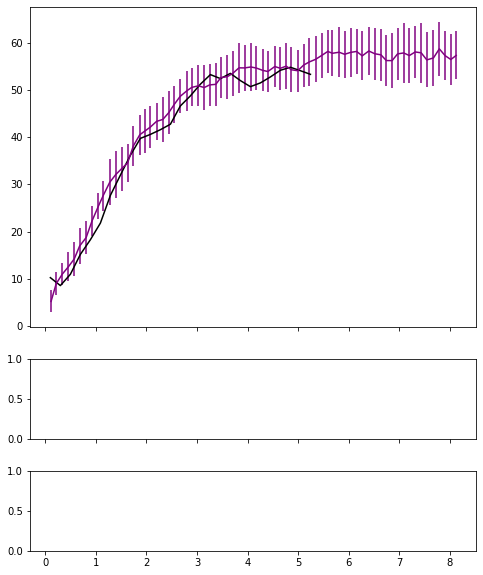

In [21]:
# Rotation Curve
fig, ax = plt.subplots(3,1,sharex = True, figsize = (8,10), gridspec_kw={'width_ratios': [1],'height_ratios': [4,1,1]})
ax[0].plot(radii, vels, color = 'black', label = "BBarolo")
ax[0].errorbar(LT_radii, LT_vels, xerr = None, yerr = LT_err, color= "purple", label = "Little Things")
ax[0].errorbar(bin_centers, mean[:,0], yerr=std[:,0], label = "MCMC Model")

# Inclination #
ax[1].errorbar(bin_centers, np.degrees(mean[:,1]), yerr = np.degrees(std[:,1]), label = "MCMC")
ax[1].plot(radii,inclination, label = "BBarolo")
# MCMC bounds
ax[1].hlines(y = (np.degrees(inc_min), np.degrees(inc_max)), xmin = 0, xmax = radii[-1],linestyle = 'dashed')
ax[1].set_ylabel("Inclination")

# Position Angle #
ax[2].errorbar(bin_centers, np.degrees(mean[:,2]), yerr = np.degrees(std[:,2]), label = "MCMC")
ax[2].plot(radii,posangle, label = "BBarolo")
# MCMC bounds
ax[2].hlines(y = (np.degrees(pos_angle_min), np.degrees(pos_angle_max)), xmin = 0, xmax = radii[-1],linestyle = 'dashed')
ax[2].set_ylabel("Position Angle")

ax[0].legend()
ax[1].legend()
ax[2].legend()

In [ ]:
import corner

ring = 0
for sampler in d.values():
    bin_samples = np.concatenate(sampler.chain[:,150:,:])
    figure = corner.corner(bin_samples, labels=['V', 'Inc', 'PA'],truths = (mean[ring]), 
                           truth_color = 'crimson',show_titles=True, color = 'royalblue')
    ring += 1

In [ ]:
autocorr_times = []
for i in range(6,7):
    ACT = d[f"saved_sampler_NGC2366_ring{i}"].get_autocorr_time()
    print(f"Bin {i}:", ACT)
    autocorr_times.append(ACT)

NameError: name 'fake_observed_2d_vel_field' is not defined